In [10]:
from src.distance_measures import analyse_video, analyse_image
from src.gaussian_noise import generate_noise_array, generate_noise
from src.preprocessing import process_image, process_video
from src.gradient_descent import find_default_params
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from tqdm import tqdm
from skimage import filters

### Hyperparameters

### Gradient Descent

In [11]:
def generate_poly(siz=800, percentile=80, degree=4):
    im = np.random.normal(size=(siz, siz))
    conf_interval_lower=[]

    for i in np.linspace(1,3,30):
        imFilt = filters.gaussian(im, i)
        conf_interval_lower.append(np.percentile(imFilt,(percentile)))

    x=np.linspace(1,3,30)
    y_lower=conf_interval_lower
    coefficients_lower = np.polyfit(x, y_lower, degree)
    polynomial_lower = np.poly1d(coefficients_lower)

    return polynomial_lower

In [87]:
size=300
L=50

def model(thresh, smooth):
    noise = generate_noise_array(size=size, threshold=thresh, smooth=smooth, amount=3)
    F, G = analyse_video(noise, L=L)
    return np.mean([i / j for i, j in zip(F, G)], axis=0)

def loss_fn(y, thresh, smooth, pthresh, psmooth, w):
    return np.sum((model(thresh, smooth) - y)**2) + w*((thresh - pthresh)**2 + 0.5*(smooth - psmooth)**2)

In [ ]:


# noise = generate_noise_array(size=400, threshold=0.2, smooth=2.4, amount=1)
siz=800
im = np.random.normal(size=(siz, siz))
conf_interval_lower=[]
conf_interval_upper=[]

for i in np.linspace(1,4,40):
    imFilt = filters.gaussian(im, i)
    conf_interval_lower.append(np.percentile(imFilt,(80)))
    conf_interval_upper.append(np.percentile(imFilt,(90)))

# plt.plot(conf_interval[:][0],conf_interval[:][1])
x=np.linspace(1,4,40)
y_lower=conf_interval_lower
y_upper=conf_interval_upper
coefficients_lower = np.polyfit(x, y_lower, 4)
coefficients_upper = np.polyfit(x, y_upper, 4)
print(coefficients_lower)
print(coefficients_upper)
polynomial_lower = np.poly1d(coefficients_lower)
polynomial_upper = np.poly1d(coefficients_upper)


# coefficients= [-0.02383184,0.23076839,-0.78856501,1.12045753]

# Generate y-values for the regression line
y_fit = polynomial_lower(x)
print(y_lower[0])
# Plot data and regression line
plt.plot(x, y_lower, 'o', label='Original data')
plt.plot(x, y_fit, 'r', label='Fitted line')
plt.legend()
plt.show()

In [88]:
skip_size=24
im_thresh = 0.3

epochs = 10
h = 0.01
learning_rate = 0.01
w_list= [2.5, 1, 0.2, 0]

path = 'images/cheese_gel.avi'

im = process_video(path, threshold=im_thresh, size=size, smooth=1, skip_size=skip_size)[0]
# im = np.array([im[0],im[3]])

GNCA_loss_all = []
GNCA_params = []

nonGNCA_loss_all = []
nonGNCA_params = []

start_values = []

frame_count = 0
for frame in [im]:
    prior_smooth, prior_thresh = find_default_params(frame)
    # for j in tqdm([(75,85),(85,90),(90,98)]):
    for k in tqdm(range(10)):
            rand_smooth = np.random.uniform(1,3)
            polynomial_lower = generate_poly(percentile=80)
            polynomial_upper = generate_poly(percentile=95)
            
            rand_noise_thresh = np.random.uniform(polynomial_lower(rand_smooth), polynomial_upper(rand_smooth))
            
            start_values.append((rand_smooth,rand_noise_thresh))
            # print(start_values)
            noise_thresh =rand_noise_thresh
            smooth =rand_smooth
            F, G = analyse_image(frame, L=L)
            y = F/G
            loss_list = []
            for w in w_list:
                for i in range(epochs):
                    loss = loss_fn(y, noise_thresh, smooth, prior_thresh, prior_smooth, w)
                    if (np.isnan(loss)):
                        break
                    grad1 = (loss_fn(y, noise_thresh+h, smooth, prior_thresh, prior_smooth, w)-loss)/h
                    grad2 = (loss_fn(y, noise_thresh, smooth+h, prior_thresh, prior_smooth,  w)-loss)/h
                    # print("thresh before: ",noise_thresh)
                    noise_thresh -= grad1 * learning_rate
                    # print("thresh: ",noise_thresh," grad1: ",grad1)
                    smooth -= grad2 * learning_rate
                    # print("smooth: ", smooth,"grad2: ",grad2)
                    # print("loss: ",loss)
                    loss_list.append(loss)
                if (np.isnan(loss)):
                    break
                # print(loss_list)
            if (np.isnan(loss)):
                continue  
            
            loss_list_2 = []
            noise_thresh_ =rand_noise_thresh
            smooth_ =rand_smooth
            for i in range(epochs*4):
                loss = loss_fn(y, noise_thresh_, smooth_, prior_thresh, prior_smooth, 0)
                if (np.isnan(loss)):
                    break
                grad1 = (loss_fn(y, noise_thresh_+h, smooth_, prior_thresh, prior_smooth, 0)-loss)/h
                grad2 = (loss_fn(y, noise_thresh_, smooth_+h, prior_thresh, prior_smooth,  0)-loss)/h
                
                noise_thresh_ -= grad1 * learning_rate
                smooth_ -= grad2 * learning_rate
                
                loss_list_2.append(loss)
            if(np.isnan(loss)):
                continue
            if (np.isnan(loss_list).any() or np.isnan(loss_list_2).any()):
                continue
            GNCA_loss_all.append( loss_list )
            GNCA_params.append( (smooth,noise_thresh) )
            nonGNCA_loss_all.append( loss_list_2 )
            nonGNCA_params.append( (smooth_,noise_thresh_) )
    frame_count+=1

# np.savetxt("twenty_parameters_nonGNCA.csv", params, delimiter=",")
# np.savetxt("twenty_loss_nonGNCA.csv", loss_all, delimiter=",")

100%|██████████| 10/10 [28:24<00:00, 170.48s/it]


In [ ]:
from skimage import filters

# noise = generate_noise_array(size=400, threshold=0.2, smooth=2.4, amount=1)
siz=800
im = np.random.normal(size=(siz, siz))
conf_interval_lower=[]
conf_interval_upper=[]

imFilt = filters.gaussian(im, 2.4)
low=np.percentile(imFilt,(95))
hi=np.percentile(imFilt,(70))
print(low)


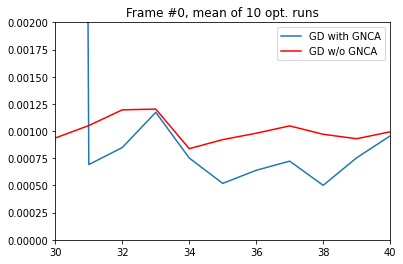

In [100]:
# GNCA_loss_all
# nonGNCA_loss_all

# np.savetxt("loss_gnca_frame0_3distributions.csv",GNCA_loss_all,delimiter=",")
# np.savetxt("loss_non_frame0_3distributions.csv",nonGNCA_loss_all,delimiter=",")
# np.savetxt("start_values_40epochs.csv",start_values,delimiter=",")

GNCA_elements = [t[-1] for t in GNCA_loss_all]
non_elements = [t[-1] for t in nonGNCA_loss_all]
# print(len(GNCA_elements))

mean_gnca = np.std(GNCA_elements,axis=0)
mean_non = np.std(non_elements,axis=0)

# mean_gnca = np.mean([GNCA_loss_all[0],GNCA_loss_all[2]],axis=0)
# mean_non = np.mean([nonGNCA_loss_all[0],nonGNCA_loss_all[2]],axis=0)
plt.plot(np.linspace(1,40,40),mean_gnca,label='GD with GNCA')
# print(nonGNCA_loss_all[4])
plt.plot(np.linspace(1,40,40),mean_non,color='red',label='GD w/o GNCA')
plt.ylim(0,0.002)
plt.xlim(30,40)
plt.title('Frame #0, mean of 10 opt. runs')
plt.legend()
# plt.plot(start_values[:][0],start_values[:][1])
# print((nonGNCA_loss_all[1]))


In [74]:
# dd=[t[-1] for t in nonGNCA_loss_all if t[0][1] == 75]
# # print(np.array(dd).shape)
# # for i in range(29):
# # print(np.array(nonGNCA_loss_all))
# comp_arrays = []
# for i in range(29):
#     if (len(nonGNCA_loss_all[i][-1]) != len(GNCA_loss_all[i][-1])):
#         comp_arrays.append()
#         # print("oh no")
# # print(np.array(nonGNCA_loss_all[7][-1]))
# # print(np.array(GNCA_loss_all[7][-1]))
#     # print()


In [85]:
# np.savetxt("loss_frame144_non_3distributions_20epochs.csv",[t[-1] for t in nonGNCA_loss_all],delimiter=",")
# last_elements = [t[-1] for t in GNCA_loss_all if t[0][1] == 75]
# print(np.array(last_elements).shape)

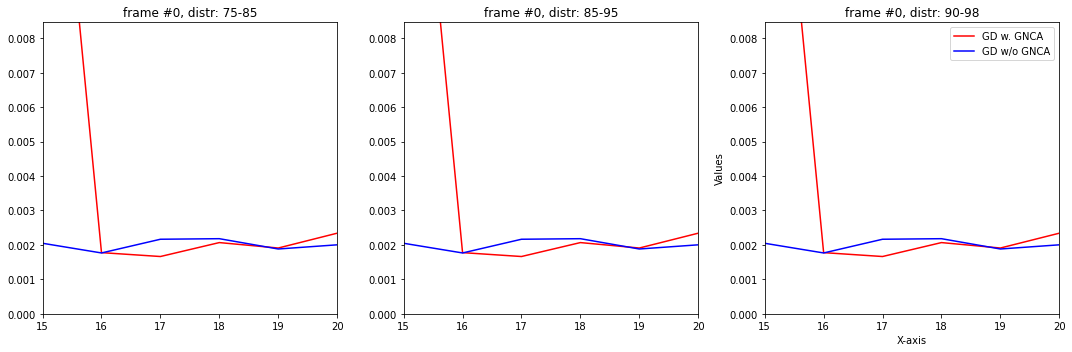

In [83]:
titles=['frame #0, distr: 75-85','frame #0, distr: 85-95','frame #0, distr: 90-98']

fig, ax = plt.subplots(1,3, figsize=(15,5))
dist=[75,85,90]
# y = np.loadtxt("/Users/Dorph/Documents/CS/3Y/Bachelor/QIM/twenty_loss_nonGNCA.csv",delimiter=",")[:25]
for k,i in enumerate([0,1,2]):
    GNCA_elements = [t[-1] for t in GNCA_loss_all if t[0][1] == dist[k]]
    non_elements = [t[-1] for t in nonGNCA_loss_all if t[0][1] == dist[k]]
    
    series1 = np.std(GNCA_elements,axis=0)
    series2 = np.std(non_elements,axis=0)

    # series2 = y[i]

    # Generate the x-axis values from 1 to 20
    x = range(1, 21)

    # Generate the first series of values
    # series1 = [0.01 * i for i in x]  # Values range from 0 to 0.2

    # Generate the second series of values
    # series2 = [0.015 * i for i in x]  # Values range from 0 to 0.3

    # Plot the two series
    ax[k].plot(x, series1, label='GD w. GNCA',color='red')
    ax[k].plot(x, series2, label='GD w/o GNCA',color='blue')

    # Set the x-axis and y-axis limits
    ylim = max(series1.min(),series2.min()) *5
    ax[k].set_xlim(15, 20)
    # plt.ylim(0, ylim)
    ax[k].set_ylim(0, ylim)

    # Set the labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Values')
    ax[k].set_title(titles[k])


plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# np.savetxt("twenty_parameters_GNCA.csv", params, delimiter=",")
# np.savetxt("twenty_loss_GNCA.csv", loss_all, delimiter=",")

### Saving values

In [ ]:
# Parameters
# np.savetxt("parameters_GNCA.csv", params, delimiter=",")

# # Loss
# np.savetxt("loss_GNCA.csv", loss_all, delimiter=",")

### Visualizations

In [ ]:
# params = [(2.5045891021805815, 0.2550168108463213), (2.5055808720933874, 0.23142073699094692), (2.515201214384155, 0.2040541179838772), (2.521388742368899, 0.18055266383708088), (2.5650979286652196, 0.1686974300694411), (2.5800816637299873, 0.16631233430992237), (2.62037301239601, 0.16369889996315873)]

In [ ]:
plt.tight_layout()
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

for i, loss in enumerate(loss_all):
    plt.plot(loss, label='Frame #{}'.format(i*skip_size))
plt.legend()
plt.show()

In [ ]:
a, t = np.array(params).T
plt.plot(a, t)
for i, (x,y) in enumerate(params):
    plt.annotate('t={}'.format(i), xy=(x,y))
    # plt.annotate('t={}, a,t=({:.02f},{:.02f})'.format(i,x,y), xy=(x,y))
plt.title('Parameters for minimizing loss between gaussian noise and video')
plt.xlabel('Smoothing (α)')
plt.ylabel('Threshold (τ)')
plt.show

In [ ]:
a, t = np.array(params).T
i = np.arange(len(a))

fig = plt.figure()

ax = plt.axes(projection ='3d')
ax.plot(a, t, i)
# for i, (x,y) in enumerate(params):
#     plt.annotate('t={}, a,t=({:.02f},{:.02f})'.format(i,x,y), xy=(x,y))
ax.set_title('Parameters for minimizing loss between gaussian noise and video')
ax.set_xlabel('Smoothing (α)')
ax.set_ylabel('Threshold (τ)')
ax.set_zlabel('Time')
plt.show

In [ ]:
# noise = generate_noise(size, threshold=t[indexC], smooth=a[-1])
# F_noise, G_noise = analyse_image(noise, L=L)
# F, G = analyse_image(im[-1], L=L)

# fig, ax = plt.subplots(2,2, figsize=(6,6))
# plt.tight_layout()

# ax[0,0].set_title('Image based off optimized params')
# ax[0,0].imshow(label2rgb(noise))
# ax[1,0].plot(F_noise/G_noise)

# ax[0,1].set_title('Last image in video')
# ax[0,1].imshow(label2rgb(im[-1]))
# ax[1,1].plot(F/G)
# plt.show()

In [ ]:
indexA= 0
indexB= 1
indexC= -1

a, t = np.loadtxt("/Users/Dorph/Documents/CS/3Y/Bachelor/QIM/twenty_parameters_GNCA.csv",delimiter=",").T
noise1 = generate_noise_array(size, threshold=t[indexA], smooth=a[indexA], amount=30)
noise2 = generate_noise_array(size, threshold=t[indexB], smooth=a[indexB], amount=30)
noise3 = generate_noise_array(size, threshold=t[indexC], smooth=a[indexC], amount=30)

params_nonGNCA = np.loadtxt("/Users/Dorph/Documents/CS/3Y/Bachelor/QIM/twenty_parameters_nonGNCA.csv",delimiter=",")[:25]
a_, t_ = np.array(params_nonGNCA).T

noise1_ = generate_noise_array(size, threshold=t_[indexA], smooth=a_[indexA], amount=30)
noise2_ = generate_noise_array(size, threshold=t_[indexB], smooth=a_[indexB], amount=30)
noise3_ = generate_noise_array(size, threshold=t_[indexC], smooth=a_[indexC], amount=30)

F1, G1 = analyse_image(im[indexA], L=L)
F2, G2 = analyse_image(im[indexB], L=L)
F3, G3 = analyse_image(im[indexC], L=L)

Fn1, Gn1 = analyse_video(noise1, L=L)
Fn2, Gn2 = analyse_video(noise2, L=L)
Fn3, Gn3 = analyse_video(noise3, L=L)

Fn1, Gn1 = np.mean(Fn1, axis=0), np.mean(Gn1, axis=0)
Fn2, Gn2 = np.mean(Fn2, axis=0), np.mean(Gn2, axis=0)
Fn3, Gn3 = np.mean(Fn3, axis=0), np.mean(Gn3, axis=0)

Fn1_, Gn1_ = analyse_video(noise1_, L=L)
Fn2_, Gn2_ = analyse_video(noise2_, L=L)
Fn3_, Gn3_ = analyse_video(noise3_, L=L)


Fn1_, Gn1_ = np.mean(Fn1_, axis=0), np.mean(Gn1_, axis=0)
Fn2_, Gn2_ = np.mean(Fn2_, axis=0), np.mean(Gn2_, axis=0)
Fn3_, Gn3_ = np.mean(Fn3_, axis=0), np.mean(Gn3_, axis=0)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].set_title('F/G of frame #0')
ax[0].plot(F1/G1, label='data')
ax[0].plot(Fn1/Gn1, label='gaussian', color='red')
ax[0].plot(Fn1_/Gn1_, label='gaussian', color='green')

ax[1].set_title('F/G of frame #72')
ax[1].plot(F2/G2, label='data')
ax[1].plot(Fn2/Gn2, label='gaussian', color='red')
ax[1].plot(Fn2_/Gn2_, label='gaussian', color='green')

ax[2].set_title('F/G of frame #144')
ax[2].plot(F3/G3, label='measurements')
ax[2].plot(Fn3/Gn3, label='synthesized_GNCA', color='red')
ax[2].plot(Fn3_/Gn3_, label='synthesized_nonGNCA', color='green')


plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

ax[0,0].set_title('video frame #0')
ax[0,0].imshow(label2rgb(im[0]))
ax[0,1].set_title('video frame #72')
ax[0,1].imshow(label2rgb(im[1]))
ax[0,2].set_title('video frame #144')
ax[0,2].imshow(label2rgb(im[-1]))

# ax[1,0].set_title('generated from frame #0')
ax[1,0].imshow(label2rgb(noise1[0]))
# ax[1,1].set_title('generated from frame #72')
ax[1,1].imshow(label2rgb(noise2[0]))
# ax[1,2].set_title('generated from frame #144')
ax[1,2].imshow(label2rgb(noise3[0]))

plt.tight_layout()
# plt.axis('off')
plt.show()

In [ ]:
from skimage.measure import regionprops
means_real = np.zeros(3)
means_gaus = np.zeros(3)
amounts_real = np.zeros(3)
amounts_gaus = np.zeros(3)

reals = [im[0], im[3], im[-1]]
gauss = [noise1[0], noise2[0], noise3[0]]

for i in range(3):
    real_regions = regionprops(reals[i])
    for real_region in real_regions:
        means_real[i] = means_real[i] + real_region.num_pixels
    means_real[i] = means_real[i] / len(real_regions)
    amounts_real[i] = len(real_regions)


    gaus_regions = regionprops(gauss[i])
    for gaus_region in gaus_regions:
        means_gaus[i] = means_gaus[i] + gaus_region.num_pixels
    means_gaus[i] = means_gaus[i] / len(gaus_regions)
    amounts_gaus[i] = len(gaus_regions)

In [ ]:
X = ['frame #0','frame #72','frame #144']
  
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, means_real, 0.4, label = 'measured', color='steelblue')
plt.bar(X_axis + 0.2, means_gaus, 0.4, label = 'synthetic', color='firebrick')

plt.tight_layout()
plt.xticks(X_axis, X)
# plt.xlabel("Groups")
plt.ylabel("Mean protein size of frame")
plt.title("Distribution of mean protein sizes")
plt.legend()
plt.show()

In [ ]:
plt.bar(X_axis - 0.2, amounts_real, 0.4, label = 'measured', color='steelblue')
plt.bar(X_axis + 0.2, amounts_gaus, 0.4, label = 'synthetic', color='firebrick')

plt.tight_layout()
plt.xticks(X_axis, X)
# plt.xlabel("Groups")
plt.ylabel("Amount of proteins of frame")
plt.title("Amounts of proteins larger than threshold")
plt.legend()
plt.show()

In [ ]:
# def stochastic_loss(thresh, disk):
#     noise = generate_noise(size=size, threshold=thresh, disk_size=disk, amount=4)
#     res_list = stochastic_analyse_video(noise, L=50)
#     return np.mean([(i[0] - y[i[1]])**2 for i in res_list])